In [4]:
#Importing imports off the top of my head
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [5]:
#each data set, not included in github
buildMetData = pd.read_csv('energyCSV/building_metadata.csv')
samSub = pd.read_csv('energyCSV/sample_submission.csv')
test = pd.read_csv('energyCSV/test.csv')
train = pd.read_csv('energyCSV/train.csv')
weather = pd.read_csv('energyCSV/weather_test.csv')

In [6]:
buildMetData

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [7]:
samSub

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [8]:
test

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00


In [9]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [10]:
weather

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6
...,...,...,...,...,...,...,...,...,...
277238,15,2018-12-31 19:00:00,3.3,NaN,1.7,NaN,1018.3,150.0,7.7
277239,15,2018-12-31 20:00:00,2.8,NaN,1.1,NaN,1017.8,140.0,5.1
277240,15,2018-12-31 21:00:00,2.8,NaN,1.7,-1.0,1017.2,140.0,6.2
277241,15,2018-12-31 22:00:00,2.8,NaN,2.2,8.0,1016.1,140.0,5.1


In [11]:
#Merging to see all data for each building/site
build = buildMetData.merge(weather, on = 'site_id')

In [12]:
build

,site_id,building_id,primary_use,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,NaN,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,0,Education,7432,2008.0,NaN,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,0,Education,7432,2008.0,NaN,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,0,Education,7432,2008.0,NaN,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,0,Education,7432,2008.0,NaN,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25273981,15,1448,Office,92271,2001.0,NaN,2018-12-31 19:00:00,3.3,NaN,1.7,NaN,1018.3,150.0,7.7
25273982,15,1448,Office,92271,2001.0,NaN,2018-12-31 20:00:00,2.8,NaN,1.1,NaN,1017.8,140.0,5.1
25273983,15,1448,Office,92271,2001.0,NaN,2018-12-31 21:00:00,2.8,NaN,1.7,-1.0,1017.2,140.0,6.2
25273984,15,1448,Office,92271,2001.0,NaN,2018-12-31 22:00:00,2.8,NaN,2.2,8.0,1016.1,140.0,5.1


## Exploring dirty data

In [13]:
build.isna().sum()

site_id                      0
building_id                  0
primary_use                  0
square_feet                  0
year_built            13531915
floor_count           19109158
timestamp                    0
air_temperature          10534
cloud_coverage        11755894
dew_temperature          26596
precip_depth_1_hr      5100401
sea_level_pressure     1983259
wind_direction         1315776
wind_speed               44874
dtype: int64

Very dirty...a lot of data missing...

In [14]:
(build['year_built'].value_counts().sum()) + (build['year_built'].isna().sum())

25273986

In [15]:
builtCount = build['year_built'].value_counts()
yearBuilt = build['year_built'].unique()

In [16]:
array = np.array(builtCount)
array2 = np.array(yearBuilt)

In [17]:
array

array([948424, 397927, 313928, 293143, 261507, 244162, 226882, 226879,
       224886, 224767, 209899, 209602, 209581, 208731, 192076, 175170,
       174642, 174393, 173454, 157440, 157395, 140152, 138872, 138734,
       122633, 122308, 121843, 121684, 121672, 121041, 105116, 105100,
       104801, 104794, 104469, 104153, 103608, 103607, 103299,  87597,
        87593,  87583,  87356,  87281,  87278,  87278,  87275,  87270,
        87268,  87267,  87125,  86962,  86954,  86639,  86636,  86413,
        86325,  85864,  70080,  70077,  70073,  70073,  70073,  70071,
        70070,  69847,  69761,  69751,  69751,  69528,  69438,  69438,
        69133,  69123,  69119,  68964,  52557,  52551,  52550,  52550,
        52549,  52548,  52324,  52323,  52238,  52235,  52234,  52233,
        35040,  35032,  35032,  34807,  34803,  34721,  34721,  34718,
        34718,  34718,  34718,  34402,  34089,  17520,  17520,  17517,
        17517,  17517,  17517,  17517,  17517,  17517,  17516,  17201,
      

In [18]:
type(builtCount)

pandas.core.series.Series

In [19]:
df = pd.DataFrame(array, columns = ['BuildCount'])

In [20]:
df['YearBuilt'] = pd.DataFrame(array2)

In [21]:
array2

array([2008., 2004., 1991., 2002., 1975., 2000., 1981., 1989., 2003.,
       2010., 1968., 1999., 2013., 1974., 1996., 1980., 1977., 1990.,
       1985., 2001., 1969., 2005., 2016., 2006., 2014., 1970., 1971.,
       2011., 1997., 2007., 1998., 2009., 1979., 1986., 1982., 1983.,
         nan, 1913., 1953., 1909., 1958., 1960., 1976., 1906., 1900.,
       1995., 1956., 1930., 1967., 1919., 1955., 1965., 1907., 2012.,
       1992., 1948., 1950., 1941., 1957., 1964., 1940., 1951., 1966.,
       1934., 1959., 1993., 1939., 1918., 1963., 1987., 1914., 1973.,
       1988., 1935., 1942., 2015., 1931., 1928., 1929., 1908., 1927.,
       1923., 1962., 1944., 1910., 1949., 2017., 1922., 1911., 1932.,
       1978., 1912., 1916., 1924., 1926., 1904., 1984., 1903., 1925.,
       1961., 1921., 1972., 1936., 1954., 1905., 1920., 1917., 1952.,
       1994., 1933., 1945., 1938., 1915., 1947., 1946., 1902., 1937.])

In [22]:
df = df.dropna()

<AxesSubplot:ylabel='YearBuilt'>

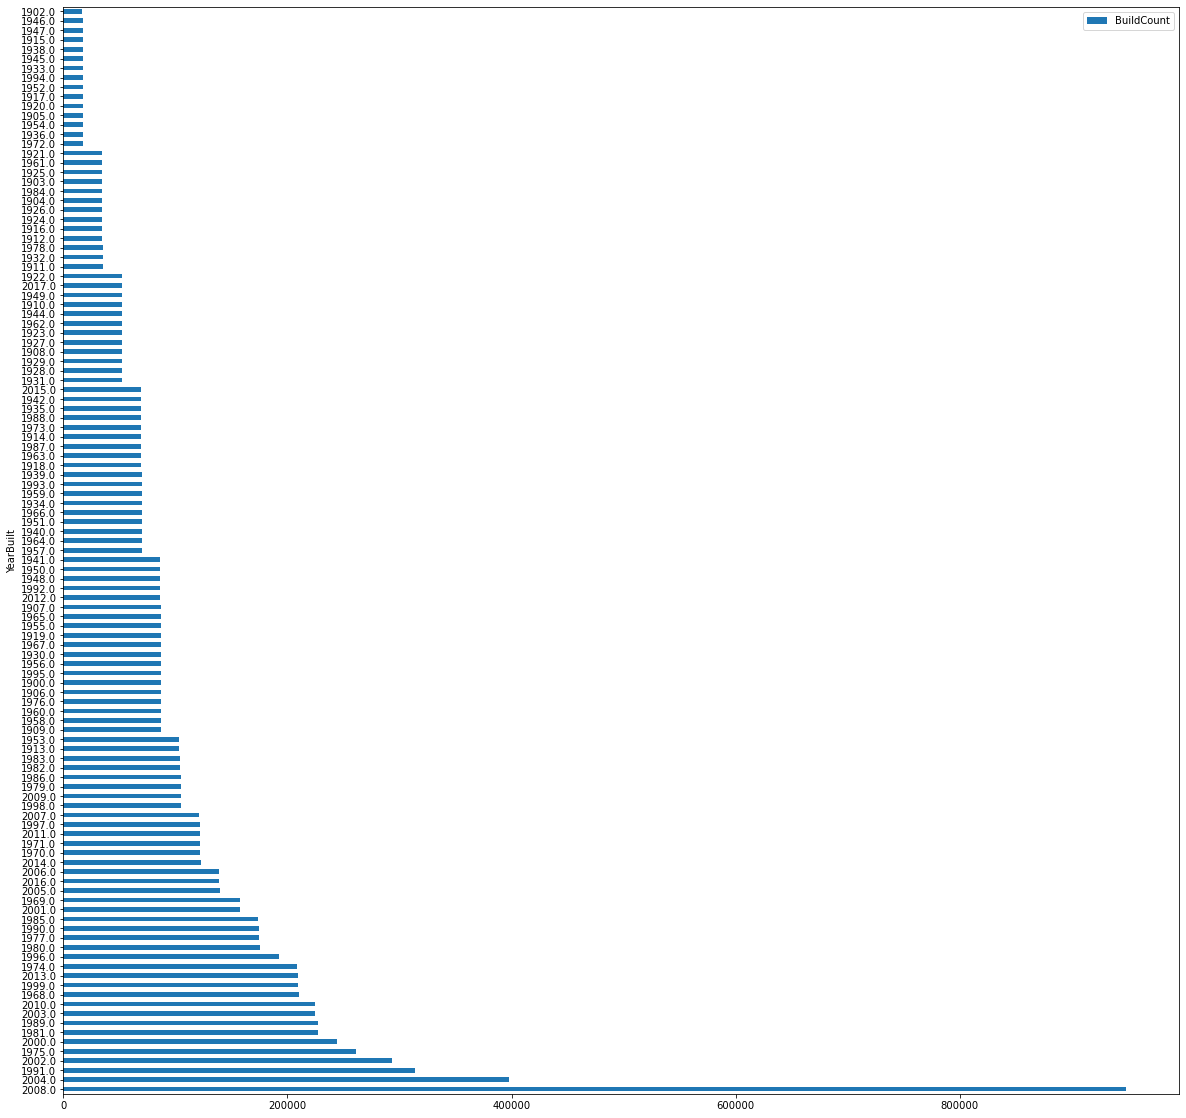

In [23]:
df.plot(kind = 'barh', x = 'YearBuilt', y = 'BuildCount', figsize = (20, 20))

In [24]:
#dataframe of just year built and count of year built
df = pd.DataFrame(build['year_built'].value_counts())

# sourt the index so years are in ascending order
df = df.sort_index(ascending = True)

#make index its own column
df['year'] = df.index

#rename new column
df = df.rename(columns = {'year_built':'yearCount'})

#make new index
s = list(range(0, 116))
moreS = pd.Series(s)
df = df.set_index(moreS)

In [25]:
df

,yearCount,year
0,87125,1900.0
1,17201,1902.0
2,52234,1903.0
3,34718,1904.0
4,17516,1905.0
...,...,...
111,157395,2013.0
112,209899,2014.0
113,52550,2015.0
114,122633,2016.0


<AxesSubplot:ylabel='year'>

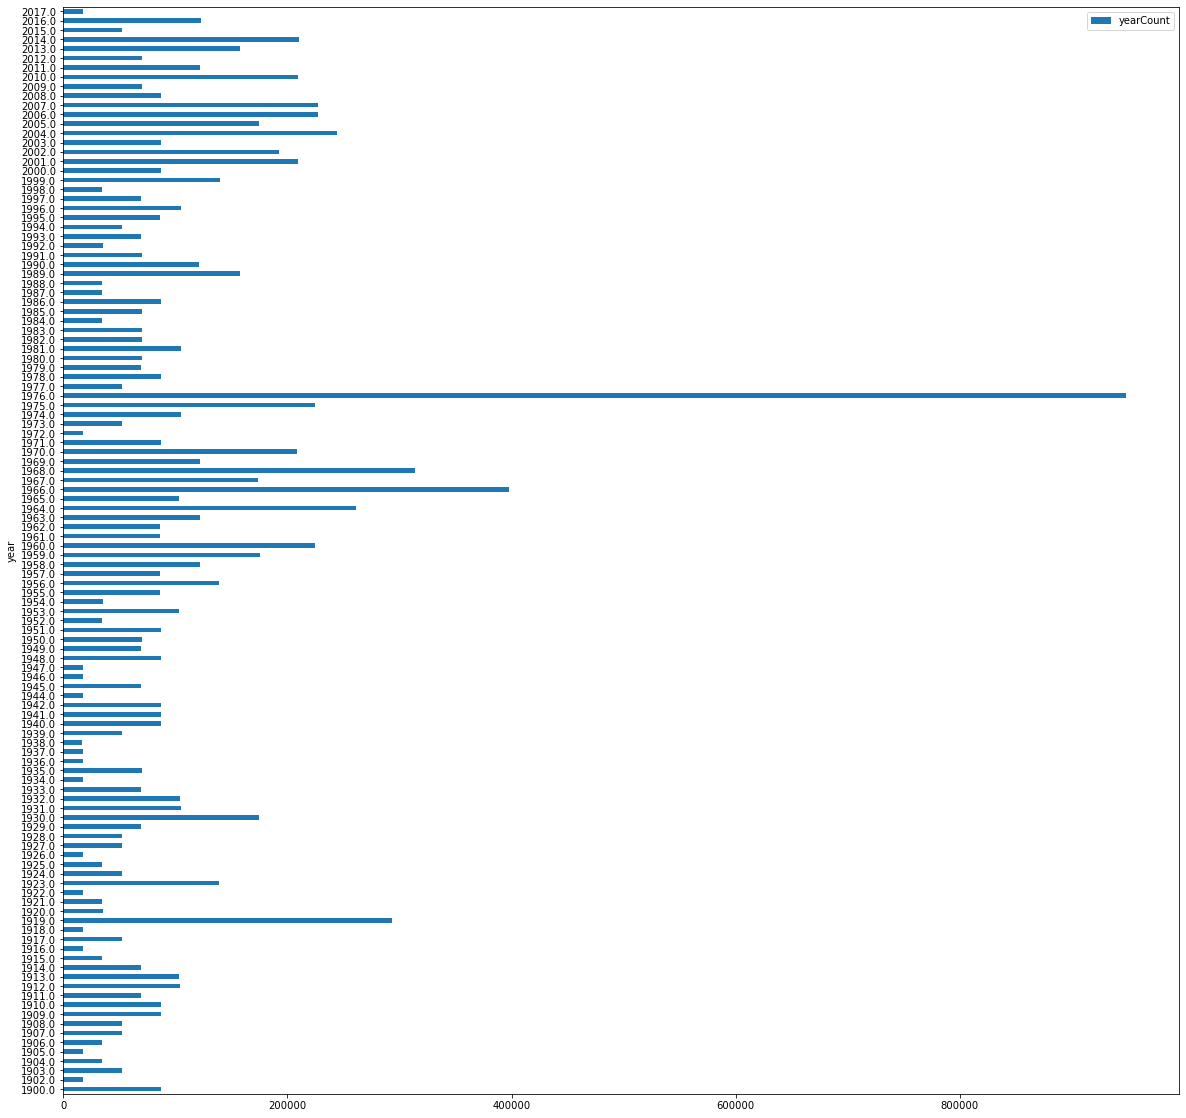

In [26]:
df.plot(kind = 'barh', figsize = (20, 20), x = 'year', y = 'yearCount')

In [27]:
df

,yearCount,year
0,87125,1900.0
1,17201,1902.0
2,52234,1903.0
3,34718,1904.0
4,17516,1905.0
...,...,...
111,157395,2013.0
112,209899,2014.0
113,52550,2015.0
114,122633,2016.0


In [28]:
df

,yearCount,year
0,87125,1900.0
1,17201,1902.0
2,52234,1903.0
3,34718,1904.0
4,17516,1905.0
...,...,...
111,157395,2013.0
112,209899,2014.0
113,52550,2015.0
114,122633,2016.0


In [29]:
build

,site_id,building_id,primary_use,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,NaN,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,0,Education,7432,2008.0,NaN,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,0,Education,7432,2008.0,NaN,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,0,Education,7432,2008.0,NaN,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,0,Education,7432,2008.0,NaN,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25273981,15,1448,Office,92271,2001.0,NaN,2018-12-31 19:00:00,3.3,NaN,1.7,NaN,1018.3,150.0,7.7
25273982,15,1448,Office,92271,2001.0,NaN,2018-12-31 20:00:00,2.8,NaN,1.1,NaN,1017.8,140.0,5.1
25273983,15,1448,Office,92271,2001.0,NaN,2018-12-31 21:00:00,2.8,NaN,1.7,-1.0,1017.2,140.0,6.2
25273984,15,1448,Office,92271,2001.0,NaN,2018-12-31 22:00:00,2.8,NaN,2.2,8.0,1016.1,140.0,5.1


In [30]:
build.isna().sum()

site_id                      0
building_id                  0
primary_use                  0
square_feet                  0
year_built            13531915
floor_count           19109158
timestamp                    0
air_temperature          10534
cloud_coverage        11755894
dew_temperature          26596
precip_depth_1_hr      5100401
sea_level_pressure     1983259
wind_direction         1315776
wind_speed               44874
dtype: int64

In [31]:
build['floor_count'].value_counts()

1.0     1901143
2.0     1159937
4.0      643759
3.0      571706
5.0      433775
6.0      433180
8.0      329067
7.0      243621
9.0      139441
11.0      86408
10.0      69606
12.0      34803
13.0      33860
14.0      17516
16.0      17287
21.0      16573
19.0      16573
26.0      16573
Name: floor_count, dtype: int64

In [32]:
build['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [33]:
test = build

In [34]:
test['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [35]:
def meanFloor(df): 
    for x in df['primary_use'].unique():
        store = []
        num = []
        phold1 = x
        df['primary_use'].loc(phold1) = 
        store.append(x)
        num.append(test['floor_count'].mean())
        test = build
        print(store, num)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [38]:
test = build
test

,site_id,building_id,primary_use,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,NaN,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,0,Education,7432,2008.0,NaN,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,0,Education,7432,2008.0,NaN,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,0,Education,7432,2008.0,NaN,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,0,Education,7432,2008.0,NaN,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25273981,15,1448,Office,92271,2001.0,NaN,2018-12-31 19:00:00,3.3,NaN,1.7,NaN,1018.3,150.0,7.7
25273982,15,1448,Office,92271,2001.0,NaN,2018-12-31 20:00:00,2.8,NaN,1.1,NaN,1017.8,140.0,5.1
25273983,15,1448,Office,92271,2001.0,NaN,2018-12-31 21:00:00,2.8,NaN,1.7,-1.0,1017.2,140.0,6.2
25273984,15,1448,Office,92271,2001.0,NaN,2018-12-31 22:00:00,2.8,NaN,2.2,8.0,1016.1,140.0,5.1


In [ ]:
m1 = (test['primary_use'] == 'Education')
test.loc[m1]